# Table of Contents
 <p><div class="lev1"><a href="#Create-the-data-pipeline-for-training-and-testing-sets"><span class="toc-item-num">1 - </span>Create the data pipeline for training and testing sets</a></div><div class="lev2"><a href="#Training-set"><span class="toc-item-num">1.1 - </span>Training set</a></div><div class="lev2"><a href="#Testing-set"><span class="toc-item-num">1.2 - </span>Testing set</a></div><div class="lev1"><a href="#Train-a-ConvNet-using-the-rectangle-method"><span class="toc-item-num">2 - </span>Train a ConvNet using the rectangle method</a></div><div class="lev1"><a href="#Loss,-predictions-and-scores"><span class="toc-item-num">3 - </span>Loss, predictions and scores</a></div><div class="lev1"><a href="#Reload-Model-and-Weights-to-perform-evaluation"><span class="toc-item-num">4 - </span>Reload Model and Weights to perform evaluation</a></div>

This notebook shows the training and testing of a ConvNet for the rectangle method applied to the Fridge appliance.

# Create the data pipeline for training and testing sets

## Training set

In [1]:
from __future__ import print_function
%matplotlib inline
from matplotlib.pylab import plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (13, 6)
plt.style.use('ggplot')
import numpy as np
import nilmtk
from nilmtk.utils import print_dict
from nilmtk import DataSet
from neuralnilm.data.loadactivations import load_nilmtk_activations
from neuralnilm.data.syntheticaggregatesource import SyntheticAggregateSource
from neuralnilm.data.realaggregatesource import RealAggregateSource
from neuralnilm.data.stridesource import StrideSource
from neuralnilm.data.datapipeline import DataPipeline
from neuralnilm.data.processing import DivideBy, IndependentlyCenter

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D
from keras.optimizers import SGD
import time


# create dictionary with train, unseen_house, unseen_appliance
def select_windows(train_buildings, unseen_buildings):
    windows = {fold: {} for fold in DATA_FOLD_NAMES}

    def copy_window(fold, i):
        windows[fold][i] = WINDOWS[fold][i]

    for i in train_buildings:
        copy_window('train', i)
        copy_window('unseen_activations_of_seen_appliances', i)
    for i in unseen_buildings:
        copy_window('unseen_appliances', i)
    return windows


def filter_activations(windows, activations):
    new_activations = {
        fold: {appliance: {} for appliance in APPLIANCES}
        for fold in DATA_FOLD_NAMES}
    for fold, appliances in activations.iteritems():
        for appliance, buildings in appliances.iteritems():
            required_building_ids = windows[fold].keys()
            required_building_names = [
                'UK-DALE_building_{}'.format(i) for i in required_building_ids]
            for building_name in required_building_names:
                try:
                    new_activations[fold][appliance][building_name] = (
                        activations[fold][appliance][building_name])
                except KeyError:
                    pass
    return activations    



NILMTK_FILENAME = './redd_data/redd.h5'
SAMPLE_PERIOD = 6
STRIDE = None
APPLIANCES = ['fridge']
WINDOWS = {
    'train': {
        1: ("2011-04-19", "2011-05-21"),
        2: ("2011-04-19", "2013-05-01"),
        3: ("2011-04-19", "2013-05-26"),
        6: ("2011-05-22", "2011-06-14"),
    },
    'unseen_activations_of_seen_appliances': {
        1: ("2011-04-19", None),
        2: ("2011-04-19", None),
        3: ("2011-04-19", None),
        6: ("2011-05-22", None),
    },
    'unseen_appliances': {
        5: ("2011-04-19", None)
    }
}

# get the dictionary of activations for each appliance
activations = load_nilmtk_activations(
    appliances=APPLIANCES,
    filename=NILMTK_FILENAME,
    sample_period=SAMPLE_PERIOD,
    windows=WINDOWS
)

# get pipeline for the fridge example
num_seq_per_batch = 64
target_appliance = 'fridge'
seq_length = 512
train_buildings = [1, 2, 3, 6]
unseen_buildings = [5]
DATA_FOLD_NAMES = (
    'train', 'unseen_appliances', 'unseen_activations_of_seen_appliances')

filtered_windows = select_windows(train_buildings, unseen_buildings)
filtered_activations = filter_activations(filtered_windows, activations)

synthetic_agg_source = SyntheticAggregateSource(
    activations=filtered_activations,
    target_appliance=target_appliance,
    seq_length=seq_length,
    sample_period=SAMPLE_PERIOD
)

real_agg_source = RealAggregateSource(
    activations=filtered_activations,
    target_appliance=target_appliance,
    seq_length=seq_length,
    filename=NILMTK_FILENAME,
    windows=filtered_windows,
    sample_period=SAMPLE_PERIOD
)


# ------------
# needed to rescale the input aggregated data
# rescaling is done using the a first batch of num_seq_per_batch sequences
sample = real_agg_source.get_batch(num_seq_per_batch=1024).next()
sample = sample.before_processing
input_std = sample.input.flatten().std()
target_std = sample.target.flatten().std()
# ------------



pipeline = DataPipeline(
    [synthetic_agg_source, real_agg_source],
    num_seq_per_batch=num_seq_per_batch,
    input_processing=[DivideBy(input_std), IndependentlyCenter()],
    target_processing=[DivideBy(target_std)]
)

Using Theano backend.
/Users/thibaut/Dropbox/Courses/am207/project_libraries/nilmtk/nilmtk/utils.py:383: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill(limit=9)
  data = data.resample(**resample_kwargs)


Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     

/Users/thibaut/Dropbox/Courses/am207/project_libraries/nilmtk/nilmtk/metergroup.py:901: UserWarning: As a quick implementation we only get Good Sections from the first meter in the meter group.  We should really return the intersection of the good sections for all meters.  This will be fixed...
  warn("As a quick implementation we only get Good Sections from"
/Users/thibaut/anaconda/envs/nilmtk-env/lib/python2.7/site-packages/pandas/tseries/base.py:155: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  val = getitem(key)
/Users/thibaut/Dropbox/Courses/am207/project_libraries/nilmtk/nilmtk/utils.py:332: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  return resampled.index[0]
/Users/thibaut/Dropbox/Courses/am207/project_libraries/nilmtk/nilmtk/utils.py:383: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill(limit=5)
  


Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     

## Testing set

In [2]:
from nilmtk import DataSet
redd = DataSet('./redd_data/redd.h5')
mains_meter = redd.buildings[unseen_buildings[0]].elec.mains()
good_sections = mains_meter.good_sections()
mains_data = mains_meter.power_series_all_data(sample_period=SAMPLE_PERIOD,
                                               sections=good_sections).dropna() 
# find the number of testing sequences in the testing set
num_test_seq = mains_data.shape[0] / seq_length

Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.


In [3]:
fridge_data = redd.buildings[unseen_buildings[0]].elec['fridge'].power_series_all_data(sample_period=SAMPLE_PERIOD,
                                               sections=good_sections).astype(np.float32).dropna()
(mains_data, fridge_data) = mains_data.align(fridge_data, join = 'right') # merge on smallest

# Train a ConvNet using the rectangle method

In [29]:
# check the dimensions of X_train
X_valid = np.empty((10*num_seq_per_batch, seq_length))
Y_valid = np.empty((10*num_seq_per_batch, 3))

for i in range(10):
    (x_valid,y_valid) = pipeline.train_generator(fold = 'unseen_appliances', source_id = 1).next()
    X_valid[i*num_seq_per_batch: (i+1)*num_seq_per_batch,:] = x_valid[:,:,0]
    Y_valid[i*num_seq_per_batch:  (i+1)*num_seq_per_batch,:] = y_valid
X_valid = np.reshape(X_valid, [X_valid.shape[0],X_valid.shape[1],1])

In [71]:
from keras.layers import Input, Dense, Flatten, MaxPooling1D
from keras.models import Model
import keras.callbacks
from keras.callbacks import ModelCheckpoint

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = [] 

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

starting_time = time.time()

# define the network architecture = Conv Net
input_seq = Input(shape = (seq_length, 1))
conv1_layer =  Convolution1D(nb_filter = 16, filter_length = 20, border_mode='valid',
                      init = 'normal', activation =  'relu')
conv1 = conv1_layer(input_seq)
conv1_maxpooling = MaxPooling1D(pool_length=2, stride=None, border_mode='valid')(conv1)
conv2 = Convolution1D(nb_filter = 32, filter_length = 3, border_mode='valid',
                      init = 'normal', activation =  'relu')(conv1_maxpooling)
flat = Flatten()(conv2)
# dense1 = Dense(4080, activation = 'relu')(flat)
# dense2 = Dense(3072, activation = 'relu')(dense1)
# dense3 = Dense(2048, activation = 'relu')(dense2)
dense4 = Dense(512, activation = 'relu')(flat)
predictions = Dense(3, activation = 'linear')(dense4)
# create the model
model = Model(input=input_seq, output=predictions)
# compile the model
# sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error',
              optimizer='Adagrad')
compiling_time = time.time() - starting_time
print('compiling time = ', compiling_time)
# record the loss history
history = LossHistory()
# save the weigths when the vlaidation lost decreases only
checkpointer = ModelCheckpoint(filepath="./tmpdata/weights_exp3.h5", save_best_only=True)
hist = model.fit_generator(pipeline.train_generator(fold = 'train'), \
                    samples_per_epoch = num_seq_per_batch*500, \
                    nb_epoch = 5, verbose = 1, callbacks=[history, checkpointer],
                   validation_data = (x_valid,y_valid), max_q_size = 50)
print('run time = ', time.time() - starting_time)

compiling time =  0.089448928833
Epoch 1/5
21440/32000 [===================>..........]

ValueError: I/O operation on closed file

In [138]:
from keras.models import model_from_json
json_string = model.to_json()
open('./tmpdata/convnet_architecture_exp3.json', 'w').write(json_string)

In [17]:
print('saving the weights ... ')
model.save_weights('./tmpdata/weights_exp3.h5', overwrite = True)
print('done saving the weights')

saving the weights ... 
done saving the weights


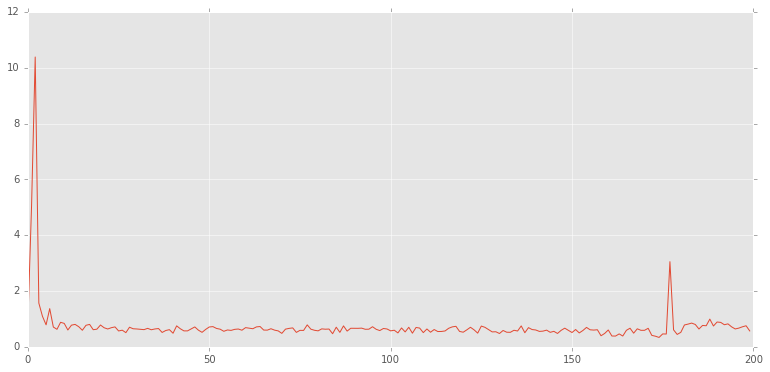

In [51]:
# show the loss history
plt.plot(history.losses)

In [52]:
conv1_weights =  conv1_layer.get_weights()[0]
conv1_biases = conv1_layer.get_weights()[1]
conv1_weights.shape

(16, 1, 3, 1)

In [67]:
model.history.epoch

[]

# Loss, predictions and scores

In [55]:
# number of sample
from neuralnilm.metrics import Metrics
score = Metrics(state_boundaries = [2.5])
Y_test = np.empty((64*num_test_seq,3))
Y_pred = np.empty((64*num_test_seq,3))
for i in range(num_test_seq):
    (x_test, y_test) = pipeline.train_generator(fold = 'unseen_appliances', source_id = 1).next()
    Y_test[64*i: 64*(i+1)] = y_test
    Y_pred[64*i: 64*(i+1)] = model.predict_on_batch(x_test)
results = score.compute_metrics(Y_pred, Y_test)
print
print(results)
    



{'regression': {'mean_squared_error': 0.634877325191325, 'relative_error_in_total_energy': 0.044860977707429, 'mean_absolute_error': 0.6008564976532713}, 'classification_2_state': {'f1_score': 0.009675190048375951, 'recall_score': 0.004901960784313725, 'accuracy_score': 0.9261035478547854, 'precision_score': 0.3684210526315789}}


In [16]:
history.params

{'do_validation': False,
 'metrics': ['loss', 'val_loss'],
 'nb_epoch': 1,
 'nb_sample': 32000,
 'verbose': 2}

# Reload Model and Weights to perform evaluation

In [64]:
from keras.models import model_from_json
model = model_from_json(open('./tmpdata/convnet_architecture.json').read())

AssertionError: Keyword argument not understood: bias

In [63]:
model.load_weights('./tmpdata/my_model_weights.h5')
model.compile(loss='mean_squared_error', optimizer='Adagrad')

Exception: You are trying to load a weight file containing 6 layers into a model with 8 layers.